In [1]:
import processing
import ds
import ml
import model_saving
import TS
import TA
# Load the necessary packages and modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import numpy as np
import math as m

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


### Processing of Data

In [109]:
filename = '/home/octo/Dropbox'+ '/SPY22Dec.csv'

In [110]:
data=processing.get_csv_pd(filename)
data=processing.BA(data)
data=processing.preprocessing_mar(data)
data_km=ml.kalman_ma(data)
data['ckm']=data.Close-data_km

In [111]:
# considering a portion of a day for analysis
data=data.dropna()
data=data[9000:19000]

In [114]:
data.head(3)

,askPrice,askSize,bidPrice,bidSize,Open,Close,High,Low,Volume,spread,Up,Dn,UD,ckm
2017-12-22 20:56:41.808071,267.34000,1.00000,267.32001,3.00000,267.33002,267.33002,267.34000,267.32001,4.00000,0.00500,0,-1,-1,0.00044
2017-12-22 20:56:42.487825,267.32999,1.00000,267.32001,3.00000,267.32501,267.33002,267.34000,267.32001,4.00000,0.00751,0,0,0,0.00040
2017-12-22 20:56:43.173107,267.32999,101.00000,267.32001,3.00000,267.32501,267.32501,267.34000,267.32001,104.00000,-0.00470,0,-1,-1,-0.00417


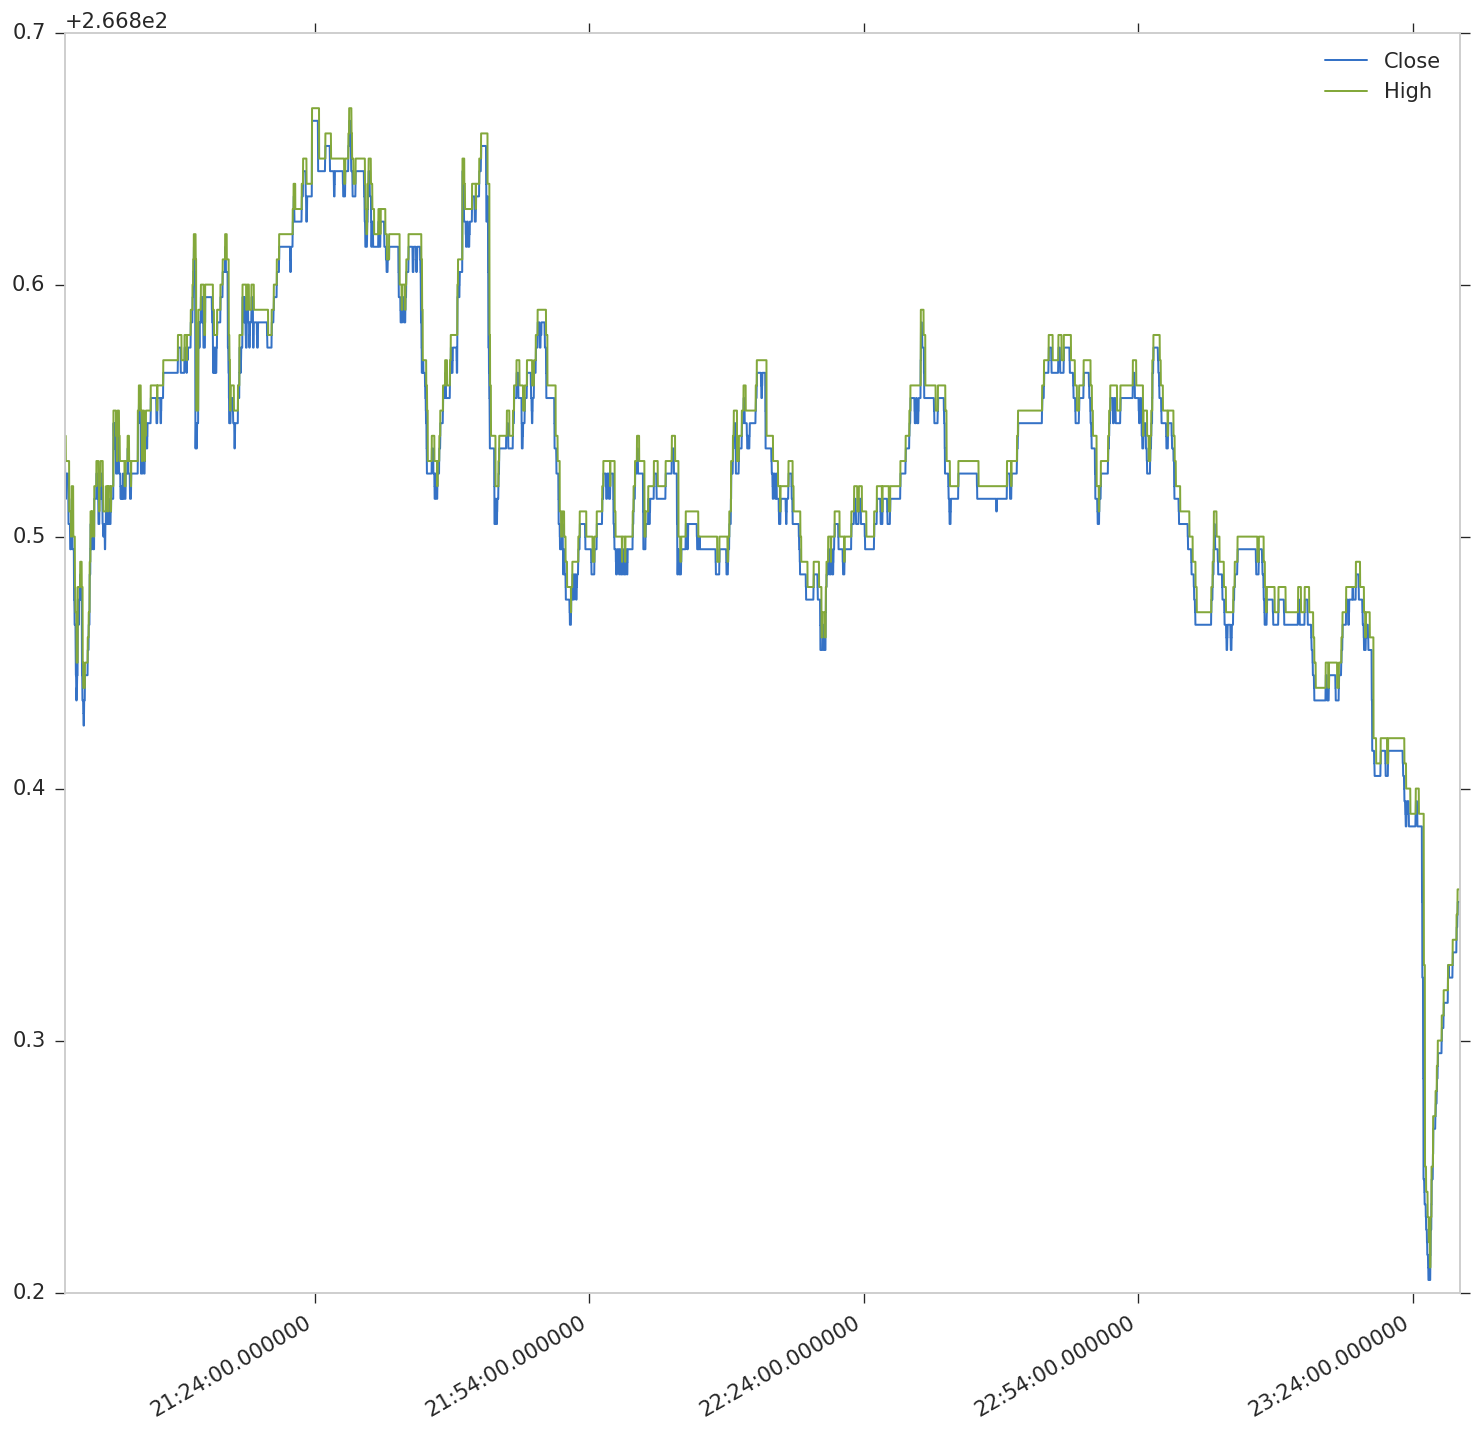

In [113]:
data[['Close','High']].plot(figsize=(15,15))
plt.show()

### Finding Up, Dn, Ud frequency==Y

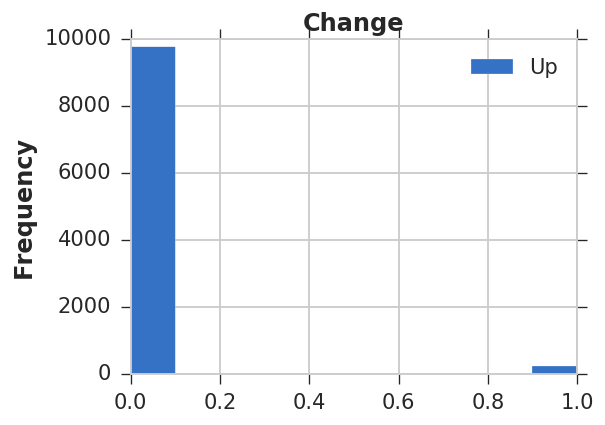

In [115]:
import matplotlib.pyplot as plt
data[['Up']].plot(kind='hist', grid=True, title='Change')
plt.show()

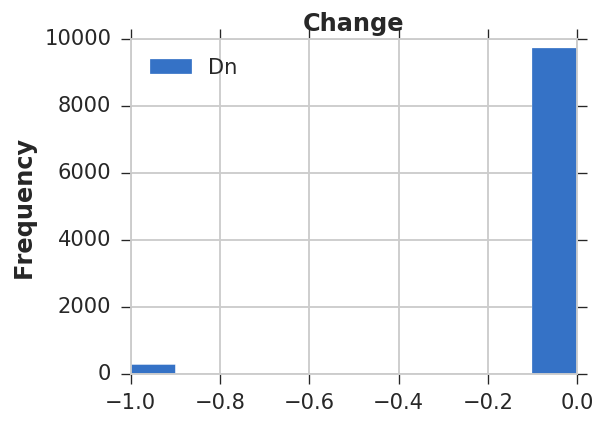

In [116]:
import matplotlib.pyplot as plt
data[['Dn']].plot(kind='hist', grid=True, title='Change')
plt.show()

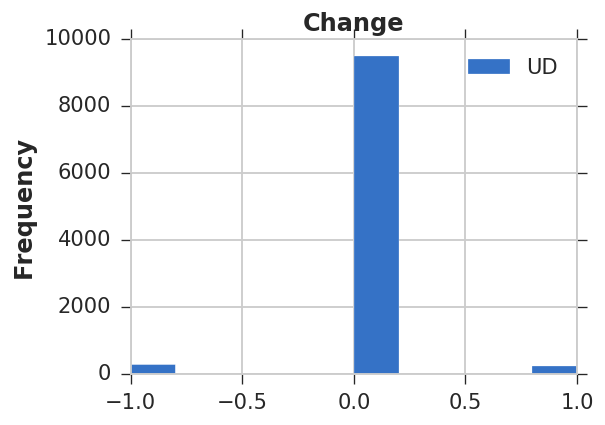

In [117]:
import matplotlib.pyplot as plt
data[['UD']].plot(kind='hist', grid=True, title='Change')
plt.show()

### Adding technical indicators

In [118]:
import talib

In [119]:
data['rsi']=talib.RSI(np.array(data.Close.astype('float64')))
data['atr']=talib.ATR(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype('float64')),timeperiod=20)
data['mom']=talib.MOM(np.array(data.Close.astype('float64')), timeperiod=5)

In [120]:
import pickle

### Outlier as a feature

http://localhost:8888/notebooks/Dropbox/trading_system/atsL2P2/L3p1_abnormal_points_model_saving.ipynb

In [121]:
data=data.dropna()

In [213]:
filename_outlr = 'outlr.sav'
outlr_loaded = pickle.load(open(filename_outlr, 'rb'))
predictions_outlr = outlr_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','spread','ckm', 'rsi', 'atr','mom']])

In [214]:
data['outlr']=predictions_outlr

    # for graph only 
    # inliers are labeled 1, outliers are labeled -1
    normal =data[predictions_outlr == 1]
    abnormal =data[predictions_outlr == -1]
    outlier_df=data.Close
    outlier_df['N']=normal.Close
    outlier_df['A']=abnormal.Close

In [215]:
# for graph only 
# inliers are labeled 1, outliers are labeled -1
outlier_df=data[['Close','outlr']]
outlier_df['N']=outlier_df.Close[outlier_df.outlr== 1]
outlier_df['A']=outlier_df.Close[outlier_df.outlr== -1]

In [216]:
print(outlier_df.groupby('outlr').size())

outlr
-1.00000    2260
1.00000     7720
dtype: int64


In [217]:
print(outlier_df.groupby('outlr').describe()[['Close']])

              Close                                                            \
              count      mean     std       min       25%       50%       75%   
outlr                                                                           
-1.00000 2260.00000 267.30637 0.06874 267.00500 267.27002 267.31500 267.34500   
1.00000  7720.00000 267.34167 0.06390 267.00500 267.30499 267.33499 267.37500   

                    
               max  
outlr               
-1.00000 267.45502  
1.00000  267.46500  


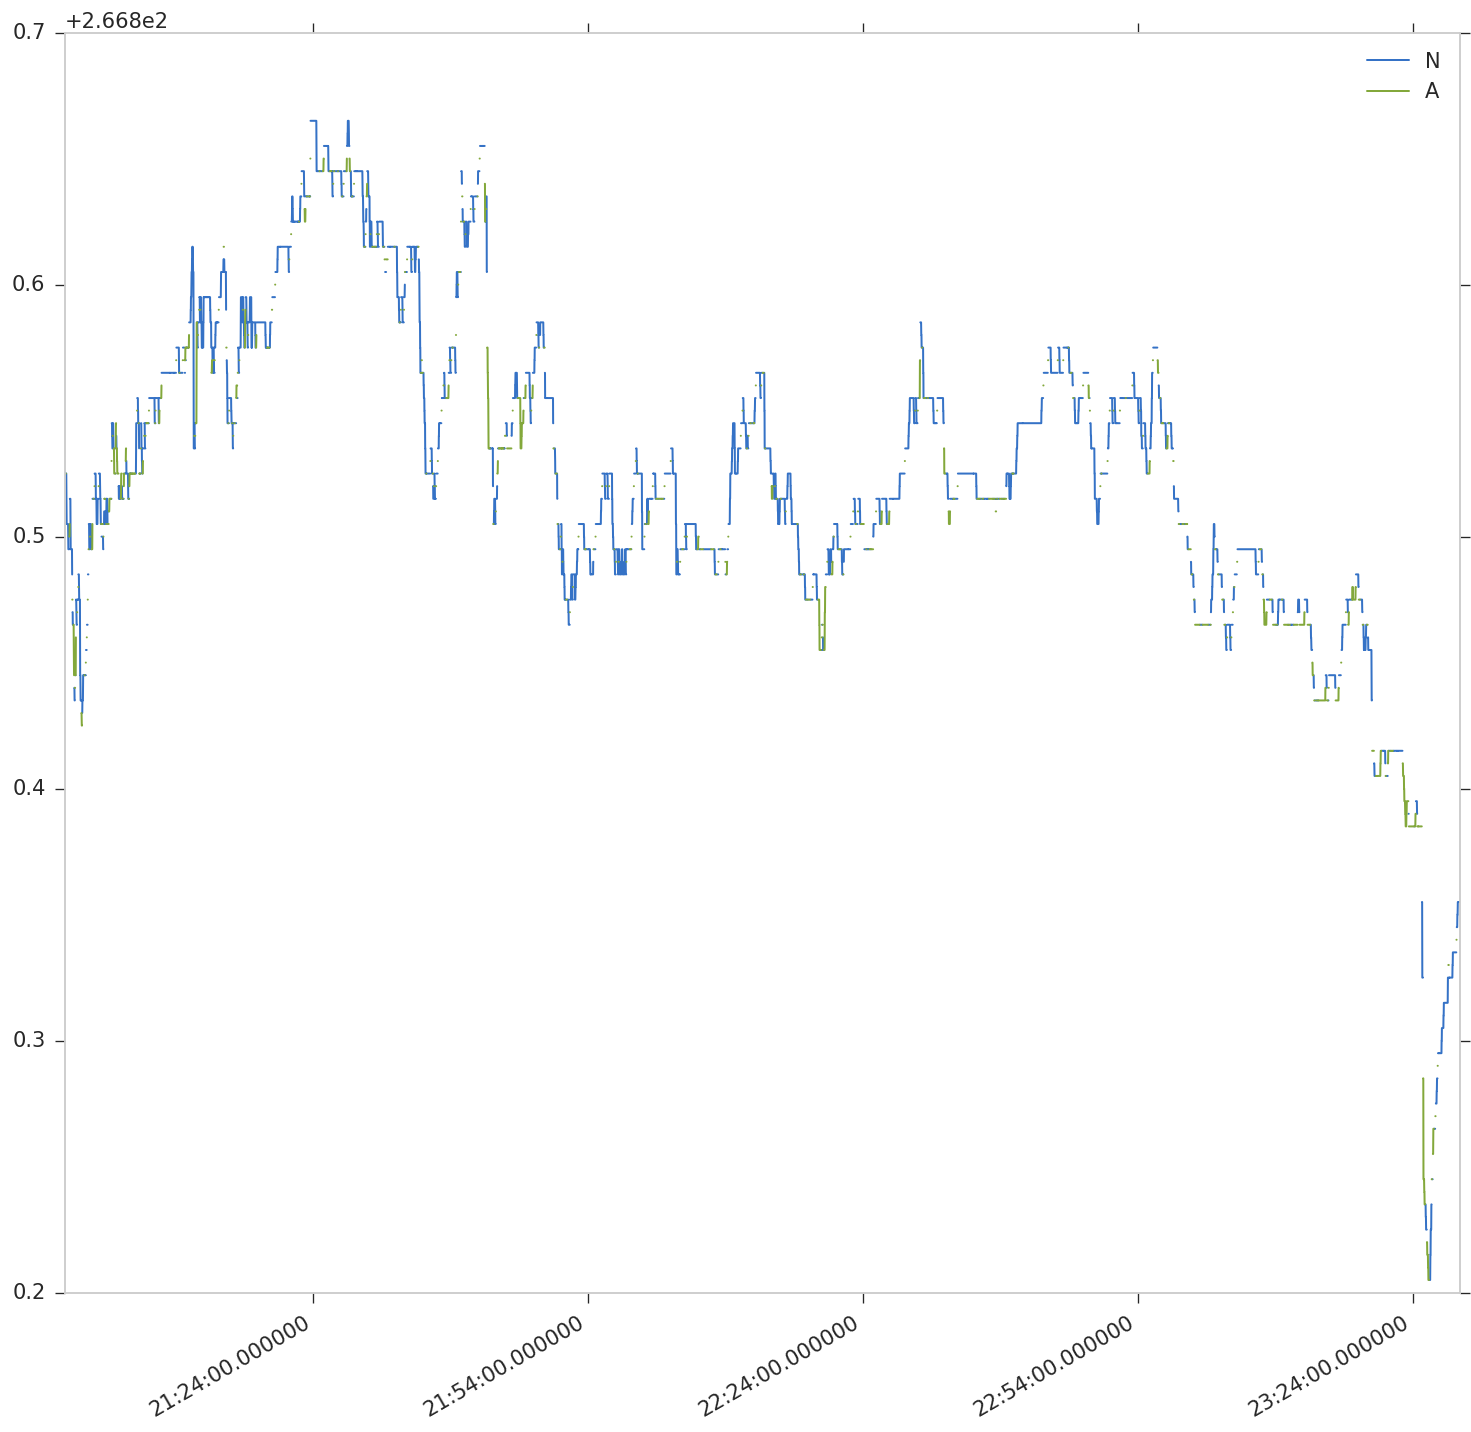

In [218]:
outlier_df[['N','A']].plot(figsize=(15,15))
plt.show()

In [220]:
# training set and test set
split_percentage=0.7
split=int(split_percentage*len(data))
# Creating trading strategy
data['ret']=np.log(data.Close/data.Close.shift(12))
cum_ret=data[split:].ret.cumsum()*100
data['strat_ret']=data.ret*data.outlr.shift(1)
cum_strat_ret=data[split:].strat_ret.cumsum()*100

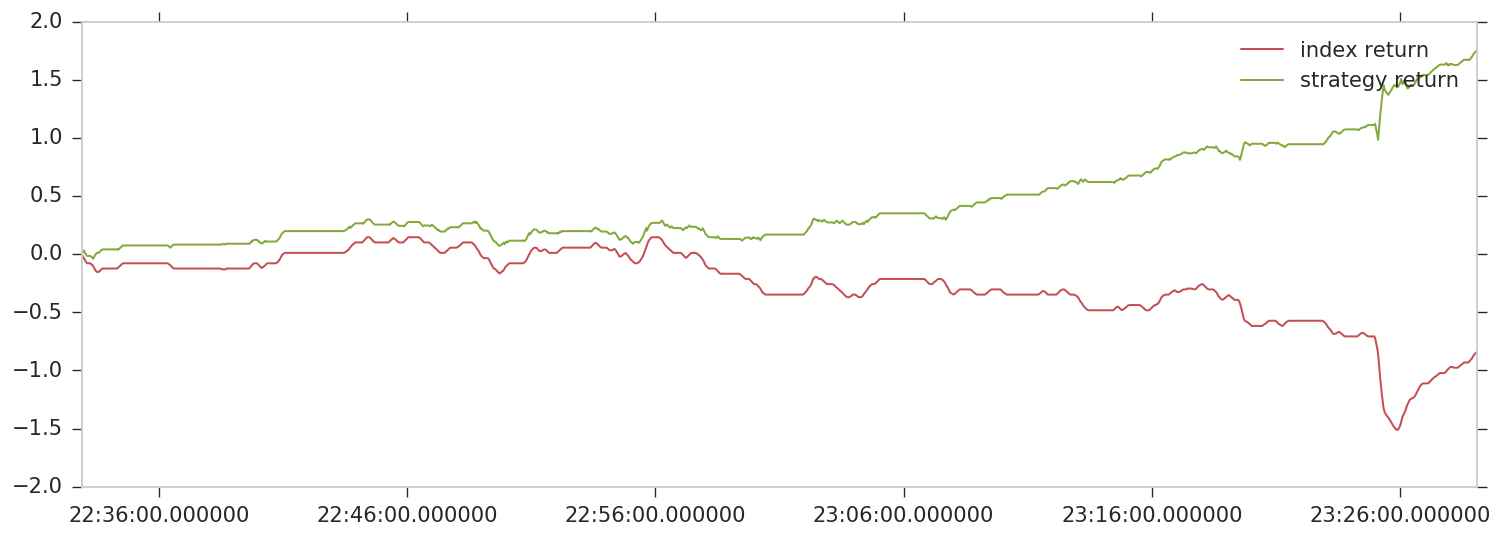

In [221]:
#plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(cum_ret,color='r',label='index return')
plt.plot(cum_strat_ret,color='g',label='strategy return')
plt.legend()
plt.show()

### Loading Markov state

In [224]:
from hmmlearn.hmm import GaussianHMM
from sklearn.externals import joblib
hmm_loaded = joblib.load("markov_hmm.pkl")  
predictions_hmm = hmm_loaded.predict(data[['Volume','spread','ckm', 'rsi','UD']])

In [225]:
data['h_state']=predictions_hmm

In [226]:
data.head()

,askPrice,askSize,bidPrice,bidSize,Open,Close,High,Low,...,ckm,rsi,atr,mom,outlr,h_state,ret,strat_ret
2017-12-22 20:56:53.992435,267.32999,5.00000,267.32001,229.00000,267.32501,267.32501,267.32999,267.31000,...,0.00235,41.85780,0.02249,0.00500,1.00000,2,nan,nan
2017-12-22 20:56:54.522351,267.32999,5.00000,267.32001,36.00000,267.32501,267.32501,267.32999,267.31000,...,0.00213,41.85780,0.02237,0.00000,-1.00000,2,nan,nan
2017-12-22 20:56:55.110564,267.32999,58.00000,267.32001,36.00000,267.32501,267.32501,267.32999,267.32001,...,0.00192,41.85780,0.02175,0.00000,-1.00000,2,nan,nan
2017-12-22 20:56:55.637001,267.32999,58.00000,267.32001,34.00000,267.32501,267.32501,267.32999,267.32001,...,0.00174,41.85780,0.02116,0.00000,-1.00000,2,nan,nan
2017-12-22 20:56:56.167781,267.32999,169.00000,267.32001,34.00000,267.32501,267.32501,267.32999,267.32001,...,0.00158,41.85780,0.02060,0.00000,1.00000,2,nan,nan


In [227]:
print("Transition matrix")
print(hmm_loaded.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(hmm_loaded.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", hmm_loaded.means_[i])
    print("var = ", np.diag(hmm_loaded.covars_[i]))
    print()

Transition matrix
[[0.      0.52767 0.47233]
 [0.23858 0.6643  0.09711]
 [0.04805 0.00958 0.94236]]

Means and vars of each hidden state
0th hidden state
mean =  [209.36201  -0.00054   0.00093  54.04047   0.13069]
var =  [23320.42398     0.00003     0.0001   1030.86643     0.98169]

1th hidden state
mean =  [226.9143    0.00036  -0.0011   45.35642   0.     ]
var =  [28807.73973     0.00004     0.00012  1197.76484     0.00001]

2th hidden state
mean =  [193.65895  -0.00105   0.00035  53.05214   0.     ]
var =  [13935.49991     0.00002     0.00002   907.17758     0.     ]



In [239]:
from matplotlib import cm, pyplot as plt
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(df)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components,
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask],
            df["spread"][mask],
            ".", linestyle='none',
            c=colour
        )
        #ax.set_title("Hidden State #%s" % i)
        #ax.xaxis.set_major_locator(YearLocator())
        #ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

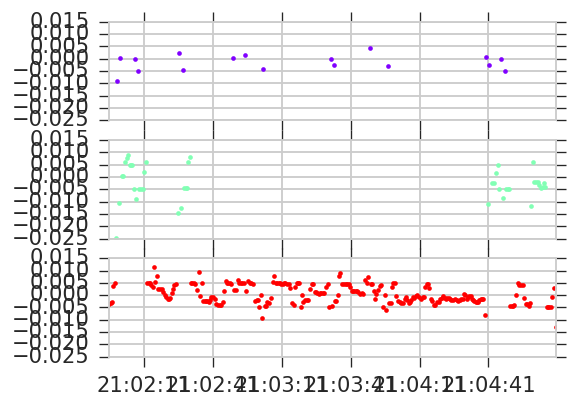

In [241]:
plot_in_sample_hidden_states(hmm_loaded,data[['Volume','spread','ckm', 'rsi','UD']][500:800])

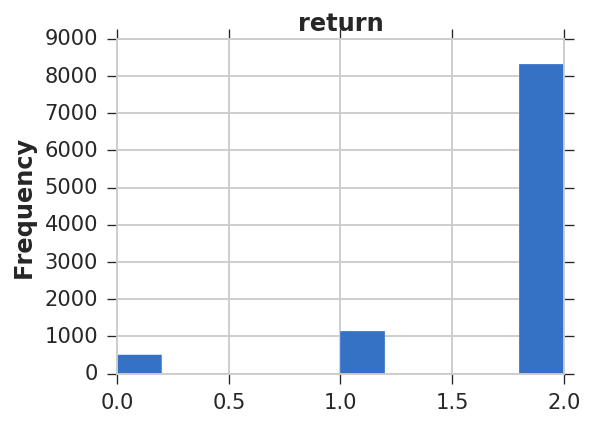

In [228]:
import matplotlib.pyplot as plt
data['h_state'].plot(kind='hist', grid=True, title='return')
plt.show()

In [229]:
# class distribution
print(data.groupby('h_state').size())

h_state
0     510
1    1149
2    8321
dtype: int64


In [237]:
pd.crosstab(index=data.h_state,columns=data.UD)      # Name the count column


UD,-1,0,1
h_state,,,
0,267,7,236
1,0,1149,0
2,0,8321,0


##### class distribution
print(data.groupby('h_state').describe()[['Close']])

 #### Here not useful  
    data[['h_state','UD']].plot(figsize=(15,15))
    plt.show()

In [154]:
import numpy as np 
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot

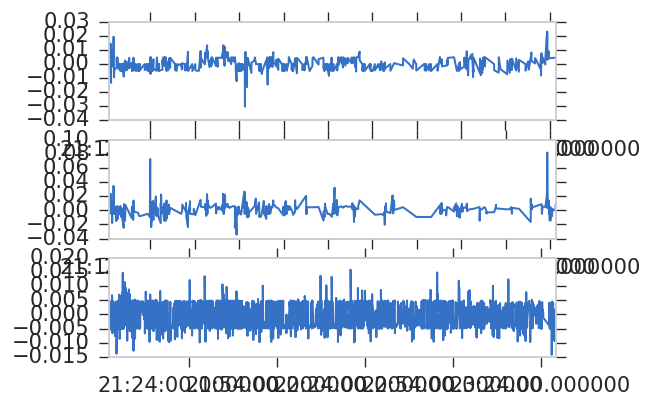

In [233]:
groups = data.spread.groupby(data.h_state)
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

# Abnormal data at state 0 will change state.

In [247]:
data['hyp']=np.where(data.outlr*data.h_state==0,0,1)

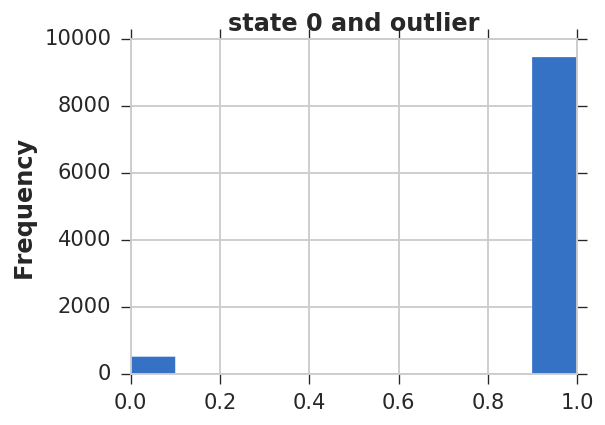

In [249]:
data.hyp.plot(kind='hist', grid=True, title='state 0 and outlier')
plt.show()

In [250]:
# class distribution
print(data.groupby('hyp').size())

hyp
0     510
1    9470
dtype: int64


### RF

In [173]:
filename_rf = 'model_rf.sav'
rf_loaded = pickle.load(open(filename_rf, 'rb'))
predictions_rf = rf_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize', 'Open', 'Close', 'High',
       'Low', 'Volume', 'spread', 'ckm', 'rsi', 'atr', 'mom']])

In [174]:
rf_loaded.score(data[['askPrice', 'askSize', 'bidPrice', 'bidSize', 'Open', 'Close', 'High',
       'Low', 'Volume', 'spread', 'ckm', 'rsi', 'atr', 'mom']],data.UD)

0.9312625250501002